In [1]:
from src.HestonModel import generate_heston_paths
import numpy as np
import esig
import matplotlib.pyplot as plt
import iisignature
import signatory
import torch
from tqdm.auto import tqdm

In [2]:
# Initial Heston parameters
kappa = 2
theta = 0.15
v_0 = theta #
rho = 0.6
sigma = 0.6
r = 0.04

S = 100
paths = 10000
steps = 100
T = 1

In [3]:
# Get Heston prices and volatilises
prices, sigs = generate_heston_paths(S, T, r, kappa, theta, v_0, rho, sigma, steps, paths, return_vol=True)

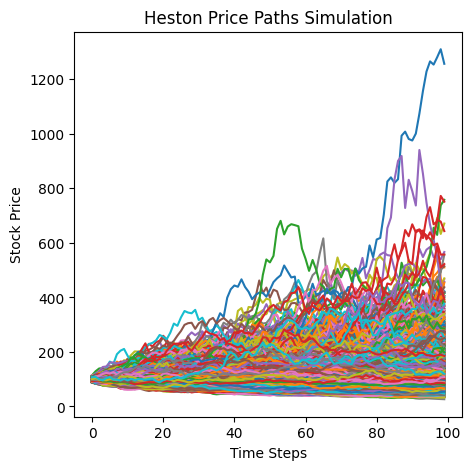

In [4]:
# Plot Heston Price paths
plt.figure(figsize=(5, 5))
plt.plot(prices.T)
plt.title('Heston Price Paths Simulation')
plt.xlabel('Time Steps')
plt.ylabel('Stock Price')
plt.show()

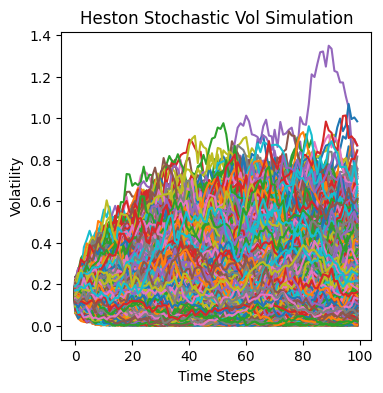

In [5]:
# Plot Heston volatility paths
plt.figure(figsize=(4, 4))
plt.plot(sigs.T)
plt.title('Heston Stochastic Vol Simulation')
plt.xlabel('Time Steps')
plt.ylabel('Volatility')
plt.show()

In [6]:
#############################################################################################

In [8]:
depth_of_sig=2  #level of truncation of signatures
width_of_sig=3  # prices + sigmas + time_array (parameters for signatures)
sig_keys = esig.sigkeys(width_of_sig, depth_of_sig)
sig_dim=signatory.signature_channels(width_of_sig,depth_of_sig)

In [ ]:
# Parameters for calculations
thetas=0.15 #Long run variance θ
kappas= 2 # Mean reversion κ
v_0s = thetas #  Initial variance
rhos = 0.6 #Correlation ρ, correlation between the log-returns and volatility of the asset
sigmas = 0.6 #Volatility of variance σ
rs = np.linspace(0.01,0.15,500)

S = 100
paths = 10000
steps = 100
T = 1

In [9]:
# define time_array and empty tensor for prices and sigmas, signatures and expected signatures
time_array = np.arange(steps)
prices_and_sigs_with_time_tensor = torch.zeros((paths,steps, width_of_sig ))
number_of_loops=rs.shape[0]
sign_ps_signatory_differentranges=torch.zeros((number_of_loops,paths,sig_dim))
Exp_sign_signatory_results=torch.zeros((number_of_loops,sig_dim))
prices_and_sigs_with_time_tensor.shape

torch.Size([10000, 100, 3])

In [10]:
def signatures_calculations_rs(S, T, rs, kappas, thetas, v_0s, rhos, sigmas, steps, paths):
    count=0
    for r in rs:
            # Caclulation of 10000 paths of prices and sigmas
            prices_1, sigs_1 = generate_heston_paths(S, T, r, kappas, thetas, thetas, rhos, sigmas, steps, paths, return_vol=True)

            for j in range(paths):
                     prices_and_sigs_with_time_tensor[j] = torch.tensor([prices_1[j], sigs_1[j], time_array]).T
                    #     shape of prices_and_sigs_witout_time_tensor=torch.Size([10000, 100, 3])

            sign_ps_signatory_differentranges[count] = signatory.signature(prices_and_sigs_with_time_tensor, depth_of_sig)
            #     shape of  sign_ps_signatory_differentranges=torch.Size([500, 10000, 12])

            Exp_sign_signatory_results[count] = torch.mean(sign_ps_signatory_differentranges[count], axis=0)
            #     shape of  Exp_sign_signatory_results=torch.Size([500, 12])

            count = count + 1
    return sign_ps_signatory_differentranges,Exp_sign_signatory_results

In [11]:
results_rs=signatures_calculations_rs(S, T, rs, kappas, thetas, v_0s, rhos, sigmas, steps, paths)
signatures_results_rs=results_rs[0]
Exp_signatures_results_rs=results_rs[1]

In [12]:
Exp_signatures_results_rs.shape

torch.Size([500, 12])

In [13]:
signatures_results_rs.shape

torch.Size([500, 10000, 12])

In [14]:
signatures_results_rs[0].shape

torch.Size([10000, 12])

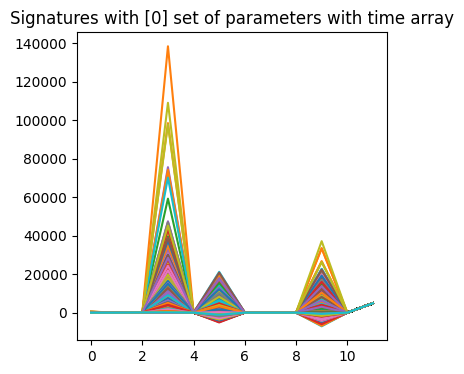

In [15]:
plt.figure(figsize=(4, 4))
plt.plot(signatures_results_rs[0].T)  #there are 512 sets of parameters
plt.title("Signatures with [0] set of parameters with time array")
plt.show()

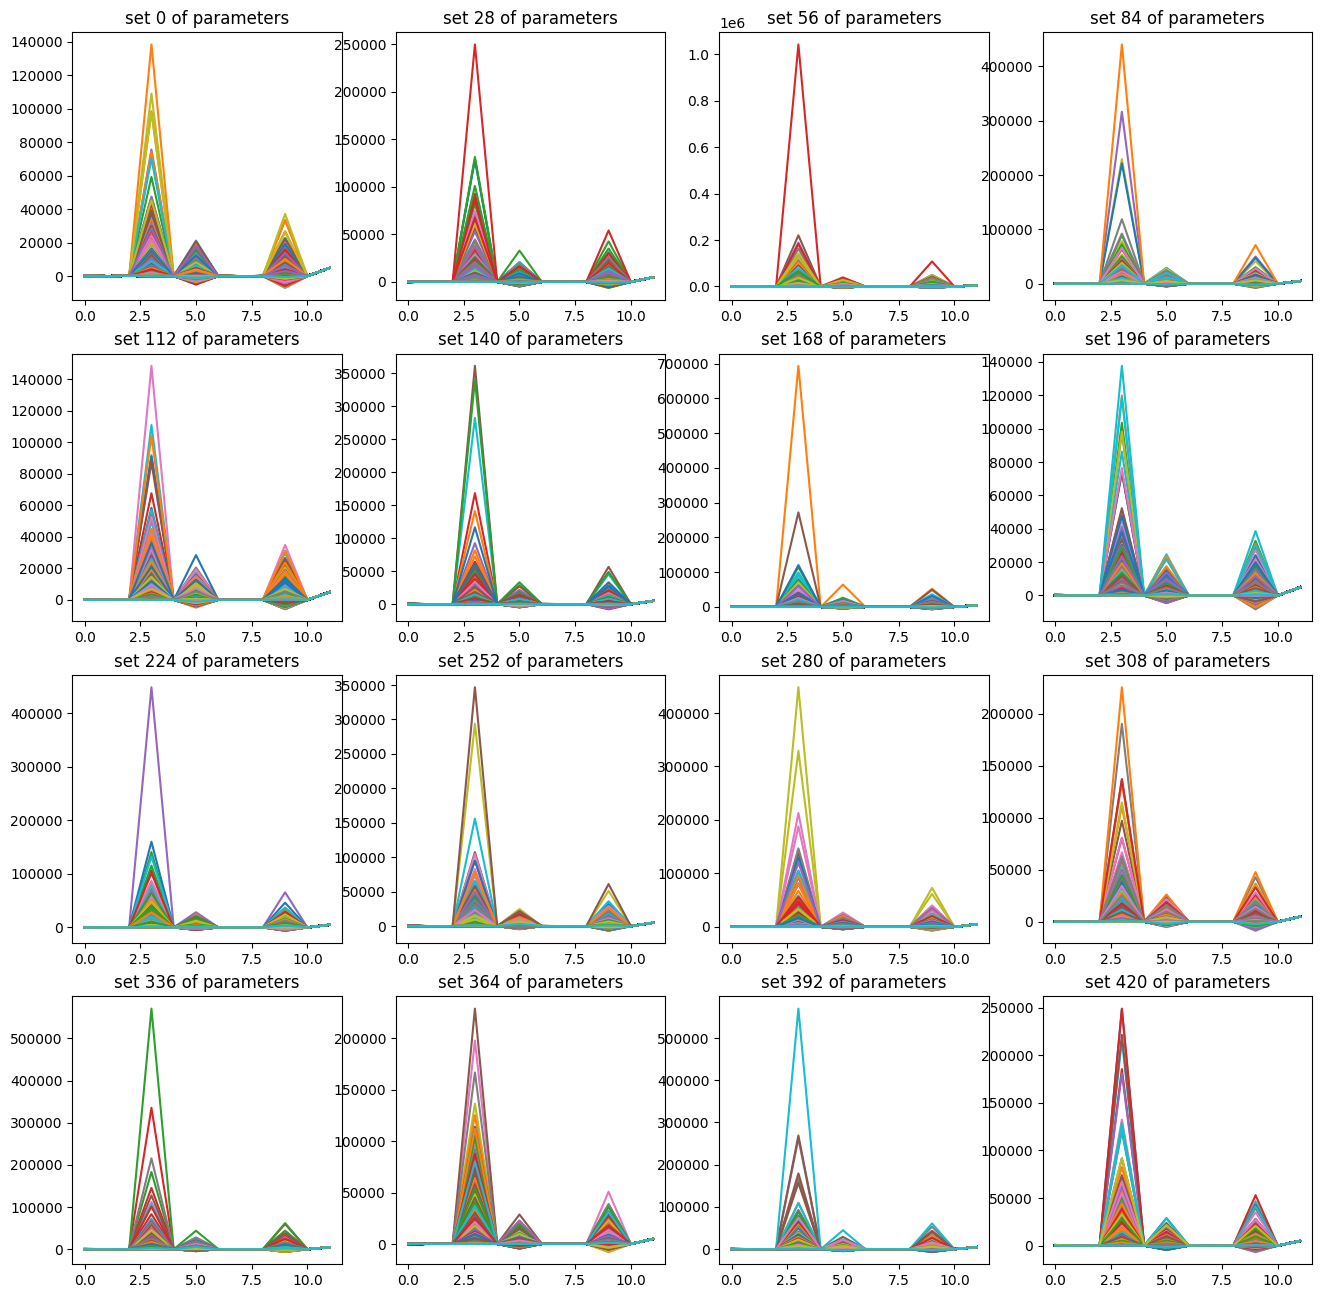

In [16]:
fig, axs = plt.subplots(4, 4, figsize=(4*4, 4*4))
axs = axs.ravel()
for i, ax in enumerate(axs):
    ax.title.set_text("set " + str(i*28)+" of parameters")
    ax.plot(signatures_results_rs[i*28].T)
#     Plot 10000 signatures for each set of parameters
#     There are big changes on each plot, which are formed on the signature keys (1,1), (1,3), (3,1)

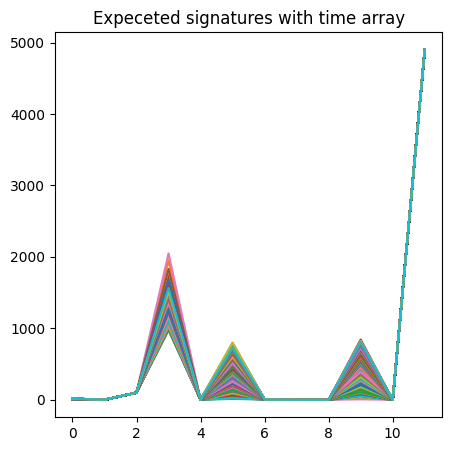

In [17]:
plt.figure(figsize=(5, 5))
plt.plot(Exp_signatures_results_rs.T[:])
plt.title("Expeceted signatures with time array")
plt.show()
# Plot 512 expected signatures

In [18]:
Exp_signatures_results_rs.T.shape

torch.Size([12, 500])

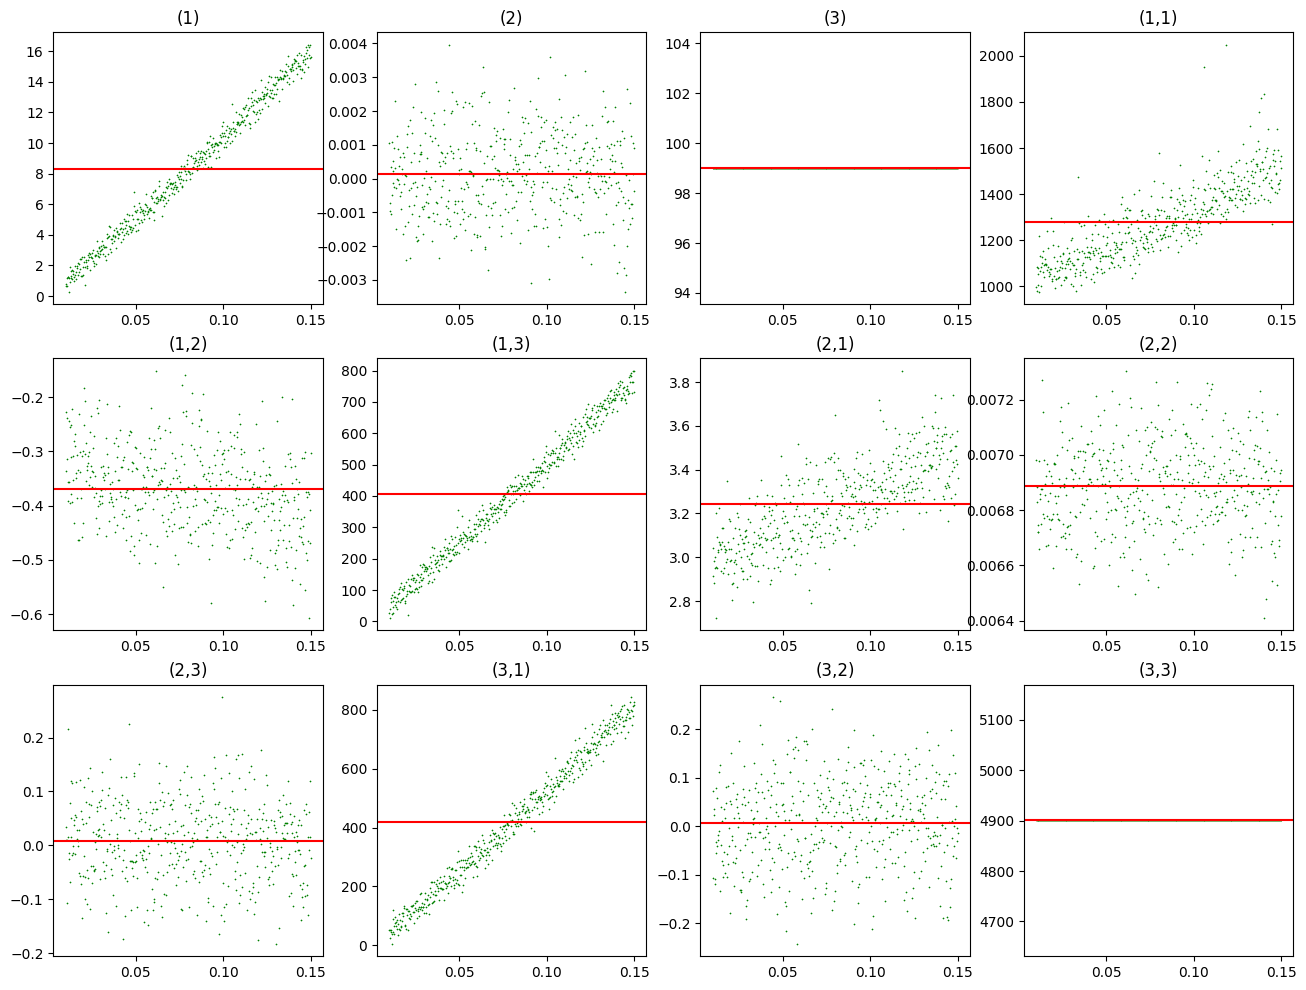

In [19]:
# Plot the scatter plots of components of the expected signatures
fig, axs = plt.subplots(3, 4, figsize=(4*4, 3*4))
axs = axs.ravel()
for i, ax in enumerate(axs):
    ax.title.set_text(sig_keys.split()[i+1])
    ax.scatter(rs,Exp_signatures_results_rs.T[i], color='green', linewidth=0.15, s=1, alpha=1)
    ax.axhline(torch.mean(Exp_signatures_results_rs.T[i]), color='red')

#     As we can observe, keys (1,2) and (2,1) have general but opposite trends with respect to parameter change.
#     So with the growth of interest rate r, the value of (1,2) tends to decrease, but the value of (2,1) tends to increase.
#     The key (1,1) also has a slight trend to increase, however it has even bigger volatily if we compare it with (2,1).
#     For time keys like (3) and (3,3) we have constant as always, since it does not change from the parameters
#     However, for the keys (1), (2) (1,3), (2,2), (2,3), (3,1) and (3,2) we cannot say anything in particular, besides that
#     they have a big volatility.

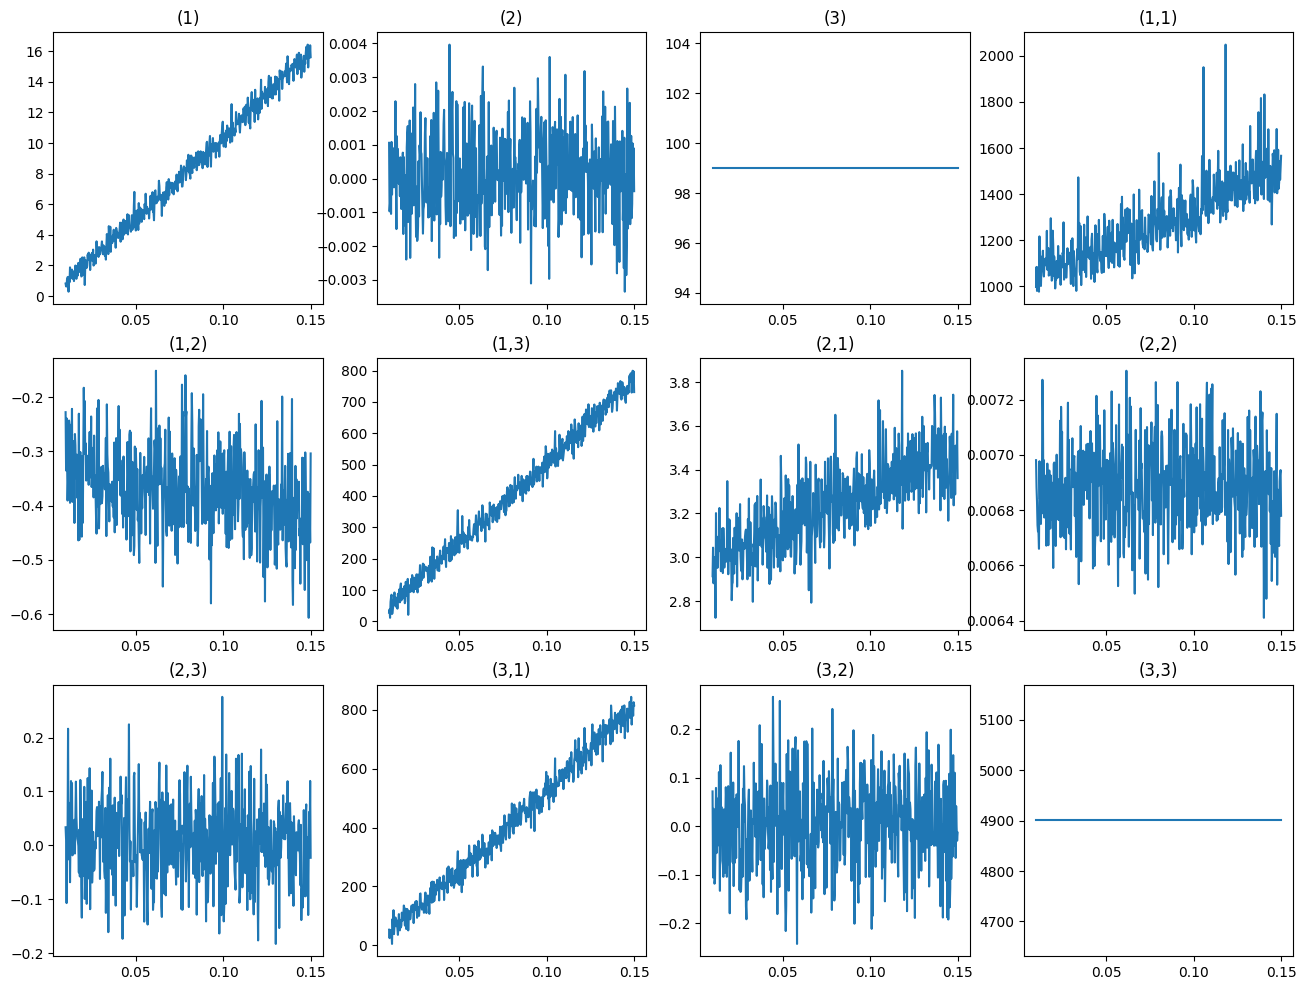

In [20]:
fig, axs = plt.subplots(3, 4, figsize=(4*4, 3*4))
axs = axs.ravel()
for i, ax in enumerate(axs):
    ax.title.set_text(sig_keys.split()[i+1])
    ax.plot(rs, Exp_signatures_results_rs.T[i])
    # ax.set_xticks([0,60,120, 180,240,300,360,420,480],[round(x,2) for x in list(rs[[0,60,120, 180,240,300,360,420,480]])])



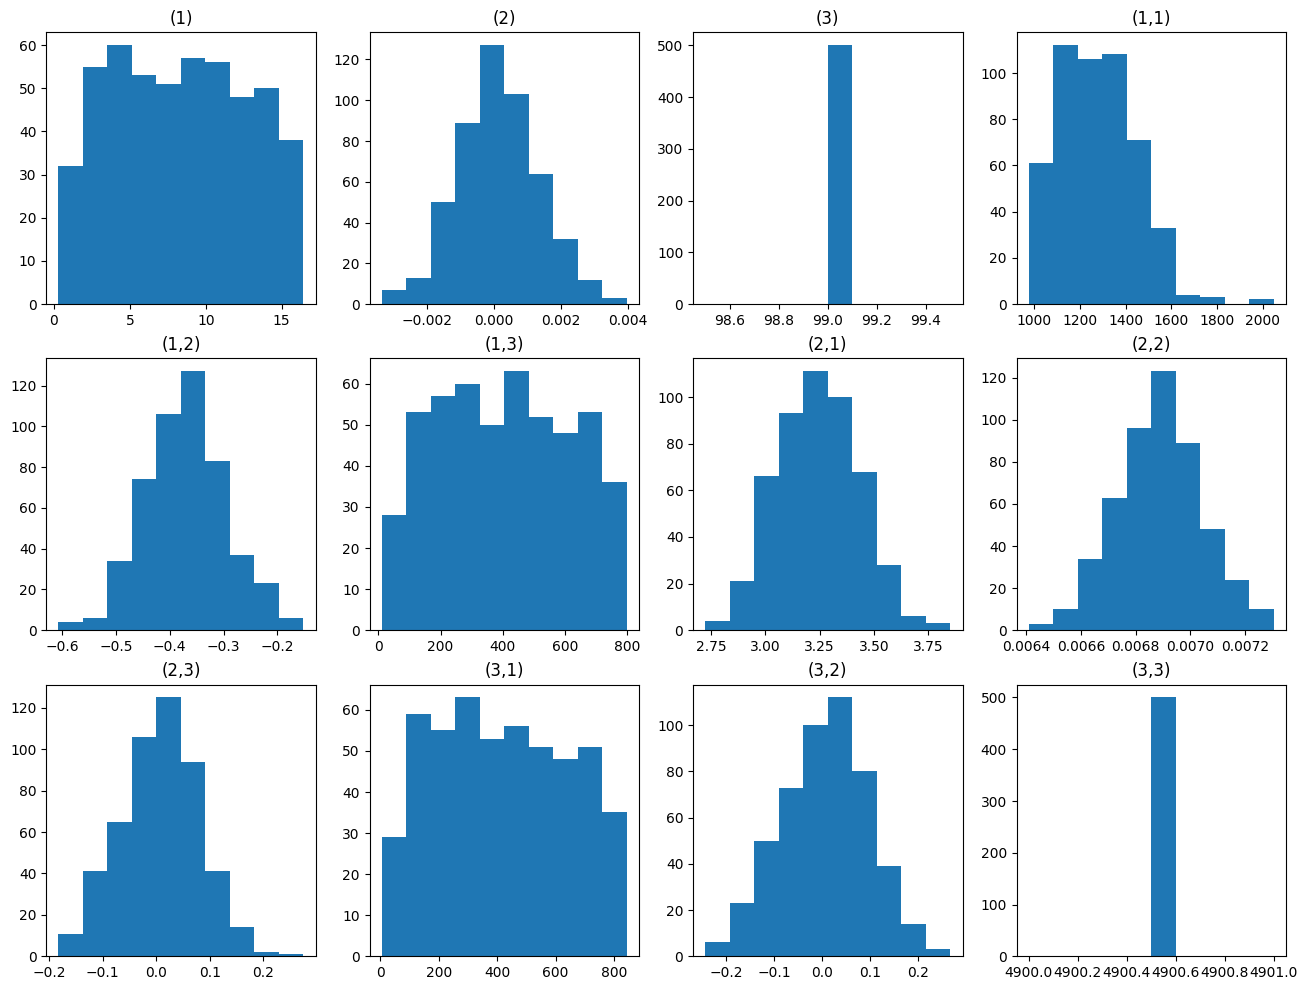

In [21]:
fig, axs = plt.subplots(3, 4, figsize=(4*4, 3*4))
axs = axs.ravel()
for i, ax in enumerate(axs):
    ax.title.set_text(sig_keys.split()[i+1])
    ax.hist(Exp_signatures_results_rs.T[i])

# Although, if you change the order of parameters in the function "signatures_calculations_with_timearray",
# the graphs of each Expected signature key are different, their histograms are similar.